In [1]:
from IPython.display import Image

In [2]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

iris = datasets.load_iris()

X = iris.data[:, [2, 3]] 
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

In [3]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # 마커와 컬러맵을 설정합니다.
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor=None if idx==1 else 'black')

    # 테스트 샘플을 부각하여 그립니다.
    if test_idx:
        # 모든 샘플을 그립니다.
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    facecolor='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

# 결정 트리 학습
* 일련의 **질문에 대한 결정을 통해 데이터를 분해**라는 모델
* 결정 트리(decision tree) 분류기는 **설명이 중요할 때** 아주 유용한 모델이다.

In [4]:
Image(url='https://git.io/Jtm21', width=500) 

* 결정 트리는 훌녀 데이터에 있는 특성을 기반으로 샐플의 클래스 레이블을 추정할 수 있는 일련의 질문을 학습.
* 트리의 루트에서 시작해서 **정보 이득(Information Gain, IG)**이 최대가 되는 특성으로 데이터를 나눔.
    * 반복 과정을 통해 리프 노드가 순수해질 때까지 모든 자식 노드에서 이 분할 작업을 반복.

### 3.6.1 정보 이득 최대화 : 자원을 최대로 활용
* 목적 함수 : 각 분할에서 정보 이득을 최대화
* 구현을 간단히 하고 탐색 공간을 줄이기 위해 이진 결정 트리를 사용.
    * 부모 모드는 두 개의 자식 노드로 나누어 짐.
    * $IG = I_p - \dfrac{n_l}{n_p}I_l - \dfrac{n_r}{n_p}I_r$

$I$ : 불순도(impurity) 지표

${n_p}$ : 부모 노드에 있는 전체 샘플 개수

* 이진 결정 트리에 사용되는 불순도 지표 또는 분할 조건
    * 지니 불순도(Gini impurity, ${I_G}$)
    * 엔트로피(entropy, ${I_H}$
    * 분류 오차(classification error, ${I_E}$)

한 노드의 모든 샘플이 같은 클래스이면 엔트로피는 0. 클래스 분포가 균등하면 엔트로피는 최대가 된다. 
* 엔트로피 조건 : 트리의 상호 의존 정보를 최대화
* 지니 불순도 : 잘못된 분류될 확률을 최소화하기 위한 기준
* 엔트로피와 비슷하게 지니 불순도는 클래스가 완벽하게 섞여 있을 때 최대

불순도 조건을 바꾸어 트리를 평가하는 것보다 가지치기 수준을 바꾸면서 튜닝하는 것이 좋다.

In [5]:
Image(url='https://git.io/Jtm2D', width=500) 

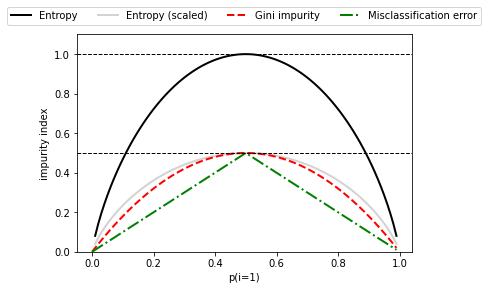

In [6]:
# 세 개의 불순도 기준을 시각적으로 비교하기 위해 클래스 1의 확률 범위 [0, 1]에 대한 불순도 인덱스
# 지니 불순도가 엔트로피와 분류 오차의 중간임을 관찰하기 위해 스케일 조정된 엔트로피(entropy / 2) 추가
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1-p))

def entropy(p):
    return -p * np.log2(p) - (1-p) * np.log2((1-p))

def error(p):
    return 1 - np.max([p, 1-p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                         ['Entropy', 'Entropy (scaled)', 'Gini impurity', 'Misclassification error'],
                         ['-', '-', '--', '-.'],
                         ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')
plt.show()

### 3.6.2 결정 트리 만들기
* 결정 트리가 깊어질수록 결정 경게가 복잡해지고 과대적합되기 쉽기 때문에 주의.
* 사이킷런을 사용하여 지니 불순도 조건으로 최대 깊이가 4인 결정 트리 훈련.

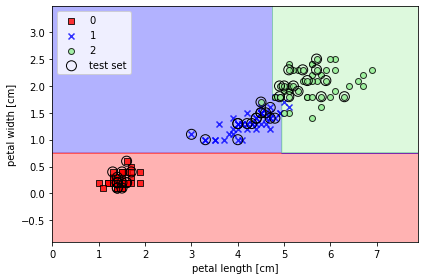

In [7]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
dt_clf.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=dt_clf,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

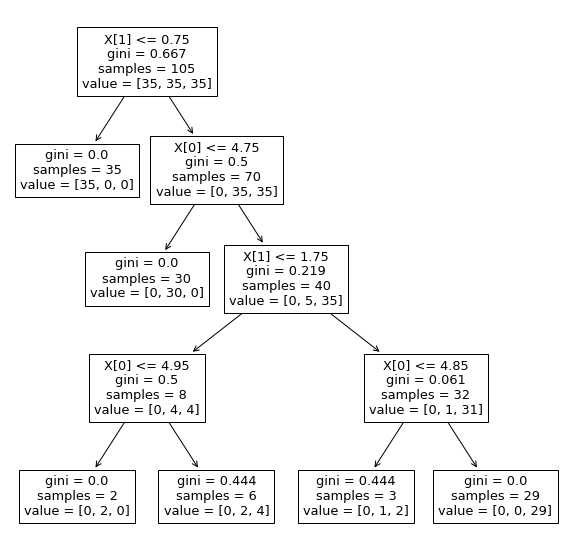

In [8]:
from sklearn import tree

plt.figure(figsize=(10, 10))
tree.plot_tree(dt_clf)
plt.show()

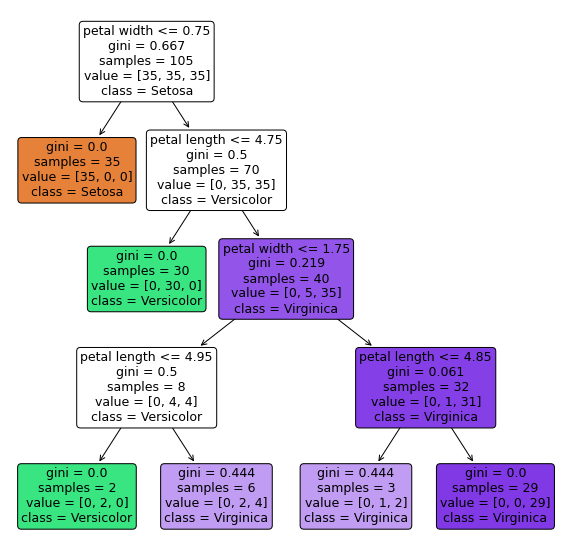

In [9]:
plt.figure(figsize=(10, 10))
tree.plot_tree(dt_clf, impurity=True, filled=True, rounded=True, 
               class_names=['Setosa', 'Versicolor', 'Virginica'], 
               feature_names=['petal length', 'petal width'])
plt.show()

In [10]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [11]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

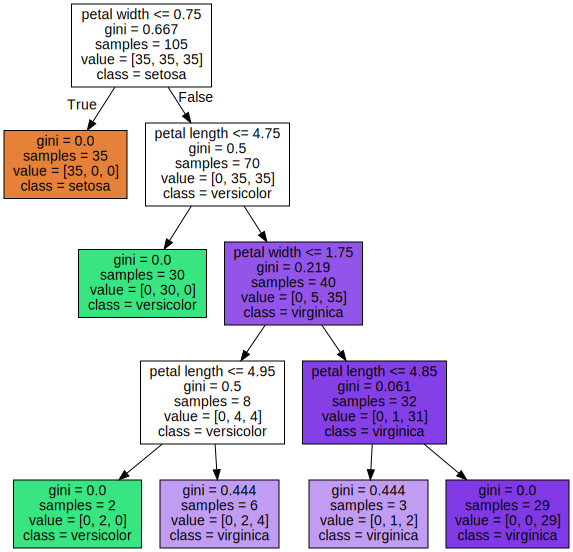

In [12]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(dt_clf, out_file="tree.dot", class_names=iris.target_names, feature_names=['petal length', 'petal width'], impurity=True, filled=True)
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

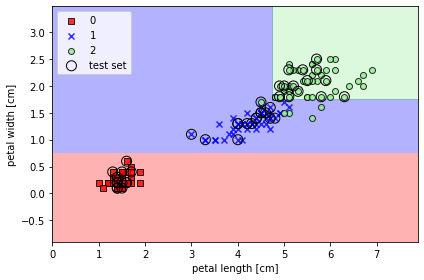

In [13]:
# max_depth = 3
from sklearn.tree import DecisionTreeClassifier
dt_clf_3 = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=1)
dt_clf_3.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=dt_clf_3,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

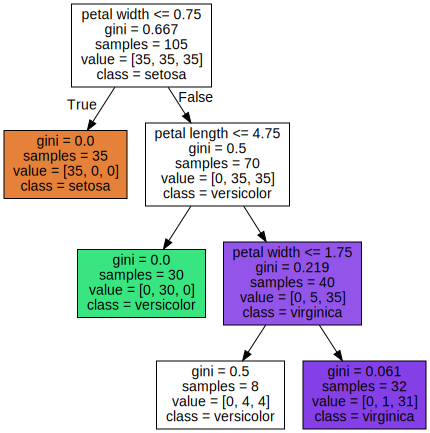

In [14]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(dt_clf_3, out_file="tree.dot", class_names=iris.target_names, feature_names=['petal length', 'petal width'], impurity=True, filled=True)
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### 3.6.3 랜덤 포레스트로 여러 개의 결정 트리 연결
* 결정 트리의 앙상블(ensemble)
* 개개의 트리는 분산이 높은 문제가 있지만, 앙상블은 견고한 모델을 만들어 일반화 성능을 높이고 과대적합의 위험을 줄임.
* 단계
    1. n개의 랜덤한 부트스트랩(bootstrap) 샘플을 뽑는다.(훈련 데이터셋에서 중복을 허용하면서 랜덤하게 n개의 샘플을 선택)
    2. 부트스트랩 샘플에서 결정 트리 학습.
        a. 중복을 허용하지 않고 랜덤하게 d개의 특성을 선택
        b. 정보 이득과 같은 목적 함수를 기준으로 최선의 분할을 만드는 특성을 사용해서 노드를 분할
    3. 단계 1~2를 k번 반복
    4. 각 트리의 예측을 모아 다수결 투표(majority voting)로 클래스 레이블 할당.

랜덤 포레스트는 가지치기를 할 필요가 없다. => 앙상블 모델이 개별 결정 트리가 만드는 잡음으로부터 안정되어 있다.

* 파라미터 튜닝 
    * 트리 개수
        * 트기의 개수가 많을수록 계산 비용이 증가하지만, 성능은 좋아진다.
    * 부트스트랩 샘플의 크기 n => 편향0분산 트레이드오프 조절
        * 부트스트랩 샘플 크기가 작아지면 개별 트리의 다양성 증가 -> 랜덤 포레스트의 무작위성 증가 -> 과대적합 영향이 줄어듬 but, 성능 감소함.
        * 부트스트랩 샘플 크기가 증가하면 과대적합 가능성 증가.
    * 분할에 사용할 특성 개수 d 
        * 훈련 데이터셋에 있는 전체 특성 개수보다 작게 지정하는 편
        * $d=\sqrt{m}$
        
$m$ : 훈련 데이터셋에 있는 특성 개수


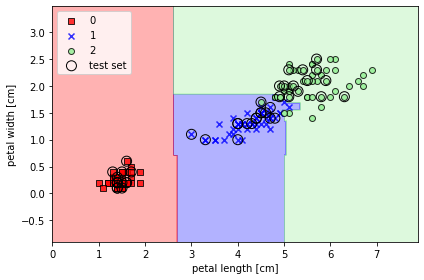

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=2)
rf_clf.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=rf_clf, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

* 랜덤 포레스트 파라미터
    * n_estimators : 랜덤 포레스트에서 결정 트리 개수 지정
        * default=10
        * 많이 설정할수록 성능 좋음. but, 오래 걸림
    * max_features : 사용할 feature 개수
        * default='auto', ['sqrt', 'auto', 'log']
    * max_depth : 트리 최대 깊이
        * default=None(완벽하게 클래스 값이 결정될 때까지 분할 or min_samples_split보다 작아질 때까지 분할)
        * 깊이가 깊어지면 과적합될 수 있음
    * min_samples_split : 노드 분할하기 위한 최소한의 샘플 데이터 수
        * 과적합 제어
        * default=2
        * 작을수록 분할 노드가 많아져 과적합 가능성 능가
    * min_samples_leaf : 리프 노드가 되기 위해 필요한 최소한의 샘플 데이터 수
        * 과적합 제어
        * 불균형 데이터의 경우 특정 클래스의 데이터가 극도로 작아질 수 있으므로 작게 설정 필요.
    * max_leaf_nodes : 리프 노드 최대 개수
    * n_jobs : 사용할 코어 개수. -1 이면, 전체


# 3.7 K-최근접 이웃(KNN) : 게으른 학습기
* 게으른 학습기 : 훈련 데이터에서 판별 함수(discriminative function)를 학습하는 대신 훈련 데이터셋을 메모리에 저장.
* 단계
    1. 숫자 k와 거리 측정 기준을 선택
    2. 분류하려는 샘플에서 k개의 최근접 이웃을 찾는다
    3. 다수결 투표를 통해 클래스 레이블을 할당


#### 모수 모델 vs 비모수 모델
* 모수 모델(parmetric model) : 새로운 데이터 포인트를 분류할 수 있는 함수를 학습하기 위해 훈련 데이터셋에서 모델 파라미터를 추정
    * 훈련이 끝나면 원본 훈련 데이터셋이 더 이상 필요하지 않는다.
    * 퍼셉트론, 로지스틱 회귀, 선형 SVM
* 비모수 모델(nonparametric model) : 고정된 개수의 파라미터로 설명될 수 없다.
    * 훈련 데이터가 늘어남에 따라 파라미터 개수도 늘어남.
    * 결정 트리, 랜덤 포레스트, 커널 SVM, KNN


In [16]:
Image(url='https://git.io/Jtm25', width=400) # k-최근접 이웃의 다수결 투표

선택한 거리 측정 기준에 따라서 KNN 알고리즘이 훈련 데이터셋에서 분류하려는 포인트와 가장 가까운 (가장 비슷한) 샘플 k개를 찾는다. 새로운 데이터 포인트의 클래스 레이블은 이 k개의 최근접 이웃에서 다수결 투표를 하여 결정.

* 메모리 기반 방식의 분류기 - KNN
    * 장점 : 수집된 새로운 훈련 데이터에 즉시 적응할 수 있는 것
    * 단점 : 새로운 샘플을 분류하는 계산 복잡도

데이터셋의 차원(특성)이 적고 알고리즘이 k-d 트리 같은 효율적인 데이터 구조로 구현되어 있지 않다면 최악의 경우 훈련 데이터셋의 샘플 개수에 선형적으로 증가. 또 훈련 단계가 없기 때문에 훈련 샘플을 버릴 수 없다. 대규모 데이터셋에서 작업한다면 저장 공간에 문제 발생.

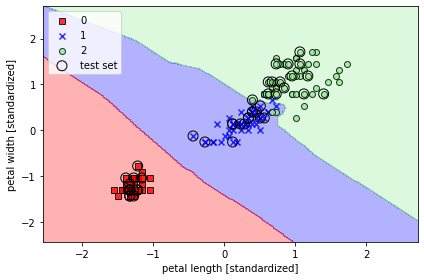

In [17]:
# 유클리디안 거리 측정 방식을 사용한 사이킷런의 KNN 모델
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski') # 5개의 이웃을 지정
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

* 동점 처리
    * 다수결 투표 동일 : 사이킷런의 KNN 구현은 분류하려는 데이터 포인트에 더 가까운 이웃을 예측으로 선택.
    * 이웃들의 거리 동일 : 훈련 데이터셋에서 먼저 나타난 샘플의 클래스 레이블 선택

##### 적절한 k 선택
* 과대적합과 과소적합 사이에서 올바른 균형을 잡기 위해 중요.
* 데이터셋의 특성에 알맞는 거리 측정 지표 선택
* 특성의 값이 실수일 경우 보통 간단한 **유클리디안** 거리 사용
    * **표준화 중요**
    * minkowski 거리는 유클리이디안 거리와 맨허튼 거리를 일반화한 것
        * $d(x^{(i)}, x^{(j)})=p\sqrt(\sum_{k}|x^{(i)}_{k}-x^{(j)}_{k}|^{p})$

ex) p=2, 유클리디안 거리. p=1, 맨허튼 거리

